In [4]:
import numpy as np
import pandas as pd

r_cols = ['userId' ,'movieId' ,'rating' ,'timestamp']
ratings = pd.read_csv('data/ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

# the movies file contains columns indicating the movie's genres
# let's only load the first five columns of the file with usecols
m_cols = ['movieId', 'title', 'release_date', 'video_release_date', 'imdb_url']
movies = pd.read_csv('data/ml-100k/u.item', sep='|', names=m_cols, usecols=range(5),
                     encoding='latin-1')

In [32]:
print(ratings.head())

   userId  movieId  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596


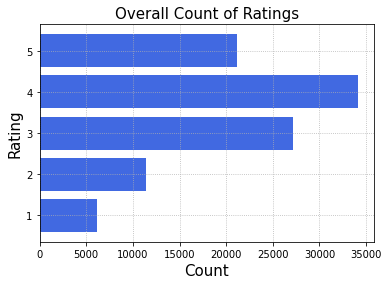

In [6]:
rts_gp = ratings.groupby(by=['rating']).agg({'userId': 'count'}).reset_index()
rts_gp.columns = ['Rating', 'Count']

plt.barh(rts_gp.Rating, rts_gp.Count, color='royalblue')
plt.title('Overall Count of Ratings', fontsize=15)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Rating', fontsize=15)
plt.grid(ls='dotted')
plt.show()

In [31]:
print(movies.head())

   movieId  ...                                           imdb_url
0        1  ...  http://us.imdb.com/M/title-exact?Toy%20Story%2...
1        2  ...  http://us.imdb.com/M/title-exact?GoldenEye%20(...
2        3  ...  http://us.imdb.com/M/title-exact?Four%20Rooms%...
3        4  ...  http://us.imdb.com/M/title-exact?Get%20Shorty%...
4        5  ...  http://us.imdb.com/M/title-exact?Copycat%20(1995)

[5 rows x 5 columns]


In [8]:
n_users = ratings.userId.unique().shape[0]
n_movies = ratings.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 943 | Number of movies = 1682


In [30]:
Ratings = ratings.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
print(Ratings.head())

movieId  1     2     3     4     5     6     ...  1677  1678  1679  1680  1681  1682
userId                                       ...                                    
1         5.0   3.0   4.0   3.0   3.0   5.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
2         4.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
3         0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
4         0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0
5         4.0   3.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0

[5 rows x 1682 columns]


In [10]:
R = Ratings.values
user_ratings_mean = np.mean(R, axis = 1)
Ratings_demeaned = R - user_ratings_mean.reshape(-1, 1)

In [11]:
sparsity = round(1.0 - len(ratings) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens1M dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens1M dataset is 93.7%


In [12]:
from scipy.sparse.linalg import svds

U, sigma, Vt = svds(Ratings_demeaned, k = 50)

In [13]:
sigma = np.diag(sigma)

In [14]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)

In [15]:
all_user_predicted_ratings.shape

(943, 1682)

In [29]:
preds = pd.DataFrame(all_user_predicted_ratings, columns = Ratings.columns)
print(preds.head())

movieId      1         2         3     ...      1680      1681      1682
0        6.488436  2.959503  1.634987  ... -0.037434 -0.025552  0.023513
1        2.347262  0.129689 -0.098917  ... -0.011760  0.011639 -0.046924
2        0.291905 -0.263830 -0.151454  ...  0.017322 -0.006644 -0.009480
3        0.366410 -0.443535  0.041151  ...  0.029984  0.015612 -0.008713
4        4.263488  1.937122  0.052529  ...  0.007603 -0.020575  0.003330

[5 rows x 1682 columns]


In [17]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = preds.iloc[user_row_number].sort_values(ascending=False) # User ID starts at 1
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.userId == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = (movies[~movies['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations

In [18]:
# Number of users = 943
already_rated, predictions = recommend_movies(preds, 469, movies, ratings, 20)

User 469 has already rated 43 movies.
Recommending highest 20 predicted ratings movies not already rated.


In [28]:
# Top 20 movies that User 469 has rated 
print(already_rated[["userId", "movieId", "rating", "title"]].head(20))

    userId  movieId  rating                                              title
0      469      513       5                              Third Man, The (1949)
15     469      923       5                       Raise the Red Lantern (1991)
39     469      607       5                                     Rebecca (1940)
36     469      603       5                                 Rear Window (1954)
34     469      507       5                   Streetcar Named Desire, A (1951)
31     469      474       5  Dr. Strangelove or: How I Learned to Stop Worr...
30     469      286       5                        English Patient, The (1996)
28     469      490       5                            To Catch a Thief (1955)
27     469      511       5                          Lawrence of Arabia (1962)
26     469      582       5                                  Piano, The (1993)
24     469       64       5                   Shawshank Redemption, The (1994)
23     469      611       5                         

In [23]:
# Top 20 movies that User 469 hopefully will enjoy
print(predictions[["movieId",	"title",	"release_date"]])

     movieId                                      title release_date
461      480                  North by Northwest (1959)  01-Jan-1959
460      479                             Vertigo (1958)  01-Jan-1958
166      178                        12 Angry Men (1957)  01-Jan-1957
485      514                          Annie Hall (1977)  01-Jan-1977
472      496               It's a Wonderful Life (1946)  01-Jan-1946
417      435  Butch Cassidy and the Sundance Kid (1969)  01-Jan-1969
409      427               To Kill a Mockingbird (1962)  01-Jan-1962
617      657           Manchurian Candidate, The (1962)  01-Jan-1962
463      482                    Some Like It Hot (1959)  01-Jan-1959
459      478             Philadelphia Story, The (1940)  01-Jan-1940
495      525                      Big Sleep, The (1946)  01-Jan-1946
578      615                       39 Steps, The (1935)  01-Jan-1935
179      191                             Amadeus (1984)  01-Jan-1984
474      498                  Afri

In [ ]:
# Import libraries from Surprise package
from surprise import Reader, Dataset, SVD, evaluate

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

# Split the dataset for 5-fold evaluation
data.split(n_folds=5)